In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, box
from scipy.spatial import cKDTree
from netCDF4 import Dataset
import xarray as xr
from shapely.ops import unary_union
from datetime import datetime, timedelta

In [3]:
def process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg):
    # Open the NetCDF-4 file
    nc = Dataset(nc_file_path, 'r')
    pixel_cloud = nc.groups['pixel_cloud']
    # Extract variables
    latitude = pixel_cloud.variables['latitude'][:]
    longitude = pixel_cloud.variables['longitude'][:]
    height = pixel_cloud.variables['height'][:]
    water_frac = pixel_cloud.variables['water_frac'][:]
    coherent_power = pixel_cloud.variables['coherent_power'][:]
    classification = pixel_cloud.variables['classification'][:]
    missed_detection_rate = pixel_cloud.variables['missed_detection_rate'][:]
    geolocation_qual = pixel_cloud.variables['geolocation_qual'][:]
    geoid_height_above_reference_ellipsoid = pixel_cloud.variables['geoid'][:]
    solid_earth_tide = pixel_cloud.variables['solid_earth_tide'][:]
    load_tide_fes = pixel_cloud.variables['load_tide_fes'][:]
    pole_tide = pixel_cloud.variables['pole_tide'][:]

    nc.close()
    # Create a pandas DataFrame
    df_PIXC = pd.DataFrame({
        'latitude': latitude,
        'longitude': longitude,
        'height': height - solid_earth_tide - load_tide_fes - pole_tide,
        'water_frac': water_frac,
        'coherent_power': coherent_power,
        'classification': classification,
        'missed_detection_rate': missed_detection_rate,
        'geolocation_qual': geolocation_qual
    })
    # Convert the DataFrame to an xarray Dataset
    ds = xr.Dataset.from_dataframe(df_PIXC)

    # Read the CSV file into a DataFrame
    df = pd.read_csv(gnss_file_path)
    
    # Create the 'geometry' column using latitude and longitude values
    df['geometry'] = df.apply(lambda row: Point(row['longitude_decimal_degree'], row['latitude_decimal_degree']), axis=1)
    
    # Convert 'day_of_year', 'year', and 'decimal_hour' into a datetime format
    # Create a new 'Datetime' column
    def convert_to_datetime(row):
        # Calculate the date from 'day_of_year' and 'year'
        date = datetime(row['year'], 1, 1) + timedelta(days=row['day_of_year'] - 1)
        # Extract hours, minutes, and seconds from 'decimal_hour'
        hours = int(row['decimal_hour'])
        minutes = int((row['decimal_hour'] - hours) * 60)
        seconds = (row['decimal_hour'] - hours - minutes / 60) * 3600
        # Create the final datetime object
        return datetime(date.year, date.month, date.day, hours, minutes, int(seconds))
    
    df['Datetime'] = df.apply(convert_to_datetime, axis=1)
    
    # Create a GeoDataFrame from the DataFrame using the 'geometry' column
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

    # Step 4: Create the 'river' GeoDataFrame and apply height correction
    # Subtract the specified value from the ellipsoidal height
    gdf['Height(m)'] = gdf['ellipsoidal_height_m'] - height_correction

    
    # Step 5: Create the 'river' GeoDataFrame with the desired columns
    river1 = gdf[['Datetime', 'geometry', 'Height(m)']] 

    if cutoff_time_1 is None and cutoff_time_2 is None:
        river = river1
    elif cutoff_time_1 is None:
        river = river1[river1['Datetime'] < cutoff_time_2]
    elif cutoff_time_2 is None:
        river = river1[river1['Datetime'] > cutoff_time_1]
    else:
        river = river1[(river1['Datetime'] > cutoff_time_1) & (river1['Datetime'] < cutoff_time_2)]
    river = river.set_crs(epsg=4326)
    
    river = river.iloc[::-1]
    river = river.to_crs(f"EPSG:{utm_epsg}").copy()
    
    petrohue_gdf = gpd.read_file(sword_shp_path)
    petrohue_gdf = petrohue_gdf.to_crs(river.crs)
    # Filter the GeoDataFrame for the specified reach_id
    petrohue_SWORD = petrohue_gdf[petrohue_gdf['reach_id'] == int(section_id)]
    # Step 2: Calculate the bounding box of the 'river' GeoDataFrame
    river_bbox = petrohue_SWORD.total_bounds  # Returns (minx, miny, maxx, maxy)
    # Convert bounding box to a GeoDataFrame
    bbox_geom = box(*river_bbox)
    bbox_gdf = gpd.GeoDataFrame(index=[0], crs=river.crs, geometry=[bbox_geom])
    # Reset index before clipping to preserve the original order
    river_reset = river.reset_index(drop=False)
    # Clip the river GeoDataFrame with the bounding box
    clipped_river = gpd.clip(river_reset, bbox_gdf)
    
    # Get the minimum and maximum index values of the clipped river
    min_index = clipped_river['index'].min()
    max_index = clipped_river['index'].max()

    # Select the rows from river that are within the min and max indices
    river = river.loc[max_index:min_index]
    
    def calculate_cumulative_distance(gdf):
        gdf['prev_geometry'] = gdf['geometry'].shift()
        gdf['distance_to_prev'] = gdf.apply(lambda row: row['geometry'].distance(row['prev_geometry']) if pd.notna(row['prev_geometry']) else 0, axis=1)
        gdf['cumulative_distance'] = gdf['distance_to_prev'].cumsum()
        return gdf
    river = calculate_cumulative_distance(river)
    river.reset_index(drop=True, inplace=True)
    # Smooth the river data such that there is only 1 point about every meter:
    # Step 1: Round the cumulative_distance to create a grouping key
    river['rounded_cumulative_distance'] = river['cumulative_distance'].round()
    
    # Step 2: Group by the rounded cumulative distance
    # We'll calculate the mean of other columns and the centroid of the geometries
    smoothed_gdf = river.groupby('rounded_cumulative_distance').agg({
        'Height(m)': 'mean',  # Replace 'column_to_smooth' with the column you want to smooth
        'cumulative_distance': 'mean',
        'geometry': lambda x: x.unary_union.centroid,  # Take the centroid of the geometries in the group
        'Datetime': lambda x: x.median(),
    }).reset_index()
    
    # Step 3: Create a new GeoDataFrame from the smoothed data
    river = gpd.GeoDataFrame(smoothed_gdf, geometry='geometry', crs=f"EPSG:{utm_epsg}")
    
    # Create a LineString from the subset
    river_line = LineString(river.geometry.tolist())
    
     # Create a GeoDataFrame for the simplified LineString
    river_line_gdf = gpd.GeoDataFrame(geometry=[river_line], crs=river.crs)
    
    # Create a buffer around the simplified LineString
    simplified_river_buffered = river_line_gdf.buffer(buffer_distance, cap_style = 'flat')
    simplified_river_buffered_gdf = gpd.GeoDataFrame(geometry=simplified_river_buffered, crs=river.crs)
    
    river_heights = river['Height(m)'].values
    river_cum_dis = river['cumulative_distance'].values
    # Convert 'ds' to GeoDataFrame and clip to buffer
    ds_gdf = gpd.GeoDataFrame({
        'latitude': latitude,
        'longitude': longitude,
        'height': height - solid_earth_tide - load_tide_fes - pole_tide,
        'water_frac': water_frac,
        'coherent_power': coherent_power,
        'classification': classification,
        'missed_detection_rate': missed_detection_rate,
        'geolocation_qual': geolocation_qual
    }, geometry=gpd.points_from_xy(df_PIXC['longitude'], df_PIXC['latitude']), crs="EPSG:4326")
    ds_gdf = ds_gdf.to_crs(f"EPSG:{utm_epsg}")
    ds_clipped = gpd.sjoin(ds_gdf, simplified_river_buffered_gdf, how='inner', predicate='within')
    # Find nearest river point to each ds point
    ds_coords_utm = np.column_stack((ds_clipped.geometry.x, ds_clipped.geometry.y))
    river_coords_utm = np.column_stack((river.geometry.x, river.geometry.y))
    
    tree_river = cKDTree(river_coords_utm)
    distances, indices = tree_river.query(ds_coords_utm)
    nearest_GNSS_height = river_heights[indices]
    nearest_GNSS_dist = river_cum_dis[indices]
    ds_clipped['nearest_GNSS_height'] = nearest_GNSS_height
    ds_clipped['nearest_GNSS_dist'] = nearest_GNSS_dist
    ds_clipped['nearest_index'] = indices
    ds_clipped['distance_to_nearest'] = distances
    # Merge DataFrames
    columns_to_keep = [col for col in ds_clipped.columns if col not in river.columns or col == 'nearest_index']
    ds_clipped_subset = ds_clipped[columns_to_keep]
    merged_df = river.merge(ds_clipped_subset, left_index=True, right_on='nearest_index', how='left')

    # These next rows will eliminate rows where there are multiple SWOT points for a GNSS point and keep the nearest.
    # Find the counts of each unique value in the 'Height(m)' column
    height_counts = merged_df['cumulative_distance'].value_counts()
    
    # Identify duplicate heights (those that occur more than once)
    duplicate_heights = height_counts[height_counts > 1].index
    
    # Filter rows with duplicate heights
    duplicate_rows = merged_df[merged_df['cumulative_distance'].isin(duplicate_heights)]
    
    # Group by 'Height(m)' and find the row with the minimum 'distance_to_nearest' for each group
    filtered_duplicates = duplicate_rows.loc[duplicate_rows.groupby('cumulative_distance')['distance_to_nearest'].idxmin()]
    
    # Filter rows with unique heights (those that occur only once)
    unique_rows = merged_df[~merged_df['cumulative_distance'].isin(duplicate_heights)]
    
    # Combine the unique rows with the filtered duplicates
    final_result = pd.concat([unique_rows, filtered_duplicates])

    #print(merged_df.head())
    # Save the combined DataFrame to a CSV file
    final_result.to_csv(output_file_path, index=False)

In [4]:
# Example usage:
section_id = '66190600041'
nc_file_path = 'data/2023-12-30/SWOT_L2_HR_PIXC_008_451_082R_20231230T085406_20231230T085417_PIC0_01.nc'
gnss_file_path = "data/2023-12-30/SEPT3640.csv"
sword_shp_path = '/home/b91g481/SWOT_analysis/data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = pd.to_datetime('2023-12-30 08:55:53.0000000000')
cutoff_time_2 = pd.to_datetime('2023-12-30 9:35:30.0000000000')
height_correction = .9283 #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

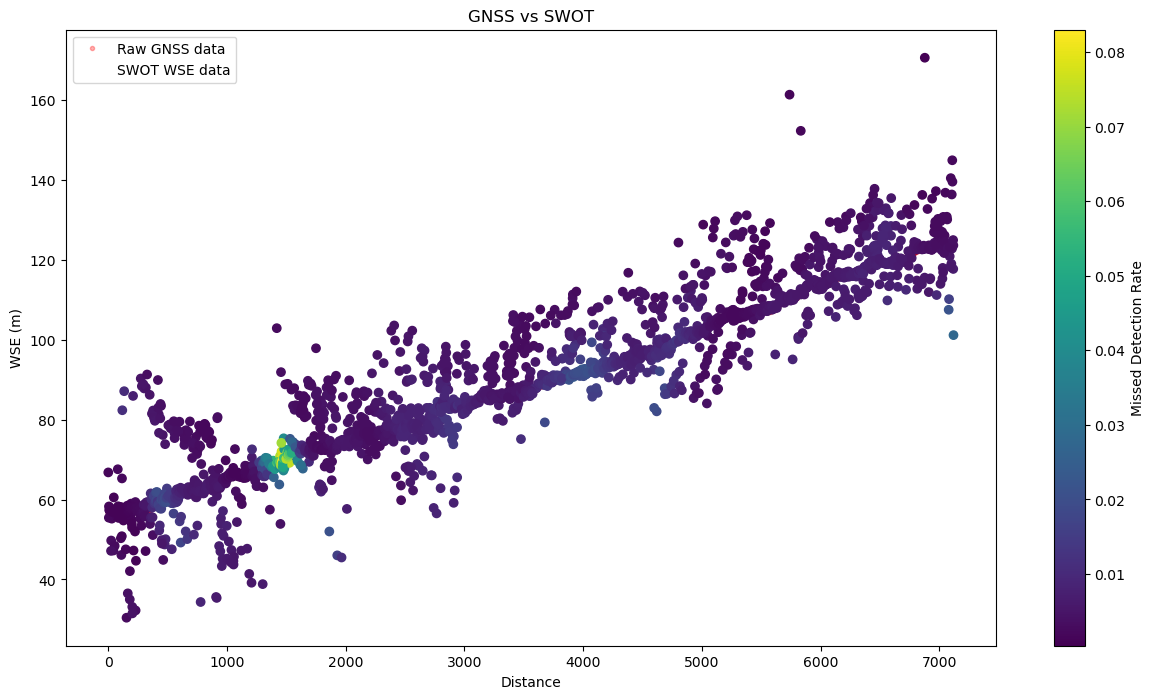

In [5]:
data = pd.read_csv(output_file_path)
data.head()

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.plot(data.cumulative_distance, data['Height(m)'], 'ro', zorder=1, markersize=3, alpha = .3, label='Raw GNSS data')
#ax.scatter(river_filtered.cumulative_distance, river_filtered['nearest_height'], color = 'royalblue', zorder=2, label='SWOT WSE data')

sc = ax.scatter(data.nearest_GNSS_dist, data['height'], 
                c=data['missed_detection_rate'], cmap='viridis', zorder=2, label='SWOT WSE data')

ax.legend()
ax.set_title('GNSS vs SWOT')
ax.set_xlabel('Distance')
ax.set_ylabel('WSE (m)')

# Add color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Missed Detection Rate')

plt.show()

In [6]:
# Example usage:
section_id = '66190600041'
date = '20240131'
nc_file_path = 'data/2023-12-30/SWOT_L2_HR_PIXC_010_188_227L_20240131T171749_20240131T171800_PIC0_01.nc'
gnss_file_path = "data/2023-12-30/SEPT3640.csv"
sword_shp_path = '/home/b91g481/SWOT_analysis/data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = pd.to_datetime('2023-12-30 08:55:53.0000000000')
cutoff_time_2 = pd.to_datetime('2023-12-30 9:35:30.0000000000')
height_correction = .9283 #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_{date}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

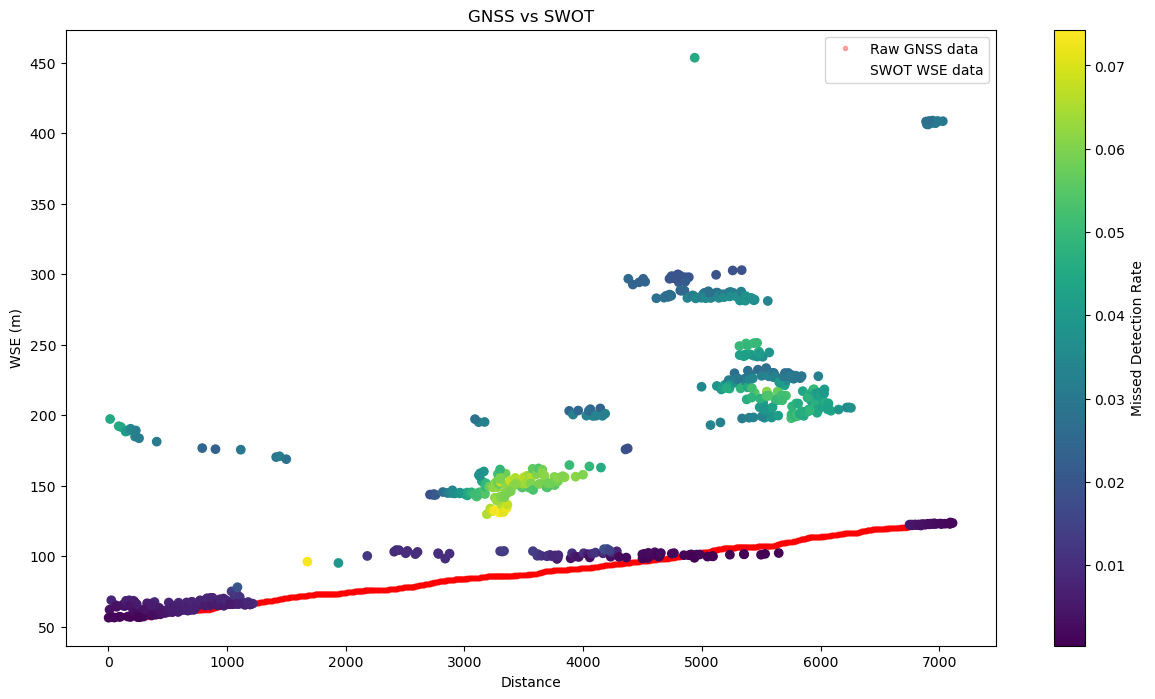

In [7]:
data = pd.read_csv(output_file_path)
data.head()

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.plot(data.cumulative_distance, data['Height(m)'], 'ro', zorder=1, markersize=3, alpha = .3, label='Raw GNSS data')
#ax.scatter(river_filtered.cumulative_distance, river_filtered['nearest_height'], color = 'royalblue', zorder=2, label='SWOT WSE data')

sc = ax.scatter(data.nearest_GNSS_dist, data['height'], 
                c=data['missed_detection_rate'], cmap='viridis', zorder=2, label='SWOT WSE data')

ax.legend()
ax.set_title('GNSS vs SWOT')
ax.set_xlabel('Distance')
ax.set_ylabel('WSE (m)')

# Add color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Missed Detection Rate')

plt.show()

In [8]:
# Example usage:
section_id = '66190600023'
nc_file_path = 'data/2024-01-09/SWOT_L2_HR_PIXC_009_145_082L_20240109T071622_20240109T071634_PIC0_01.nc'
gnss_file_path = "/home/b91g481/SWOT_analysis/final_scripts/data/2024-01-09/SEPT0092.csv"
sword_shp_path = '/home/b91g481/SWOT_analysis/data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = pd.to_datetime('2024-01-09 05:25:52.0000000000')
cutoff_time_2 = None
height_correction = 1.148 #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

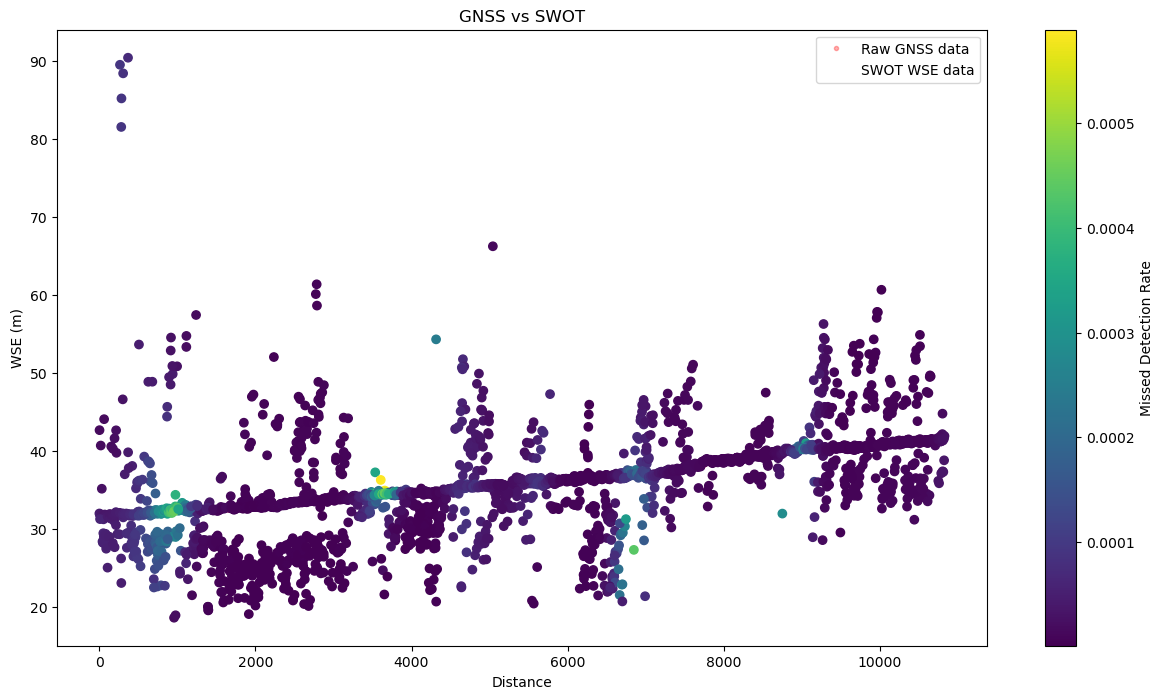

In [9]:
data = pd.read_csv(output_file_path)
data.head()

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.plot(data.cumulative_distance, data['Height(m)'], 'ro', zorder=1, markersize=3, alpha = .3, label='Raw GNSS data')
#ax.scatter(river_filtered.cumulative_distance, river_filtered['nearest_height'], color = 'royalblue', zorder=2, label='SWOT WSE data')

sc = ax.scatter(data.nearest_GNSS_dist, data['height'], 
                c=data['missed_detection_rate'], cmap='viridis', zorder=2, label='SWOT WSE data')

ax.legend()
ax.set_title('GNSS vs SWOT')
ax.set_xlabel('Distance')
ax.set_ylabel('WSE (m)')

# Add color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Missed Detection Rate')

plt.show()

In [10]:
# Example usage:
section_id = '66190600033'
nc_file_path = 'data/2024-01-09/SWOT_L2_HR_PIXC_009_145_082L_20240109T071622_20240109T071634_PIC0_01.nc'
gnss_file_path = "/home/b91g481/SWOT_analysis/final_scripts/data/2024-01-09/SEPT0092.csv"
sword_shp_path = '/home/b91g481/SWOT_analysis/data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = pd.to_datetime('2024-01-09 05:25:52.0000000000')
cutoff_time_2 = None
height_correction = 1.148 #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

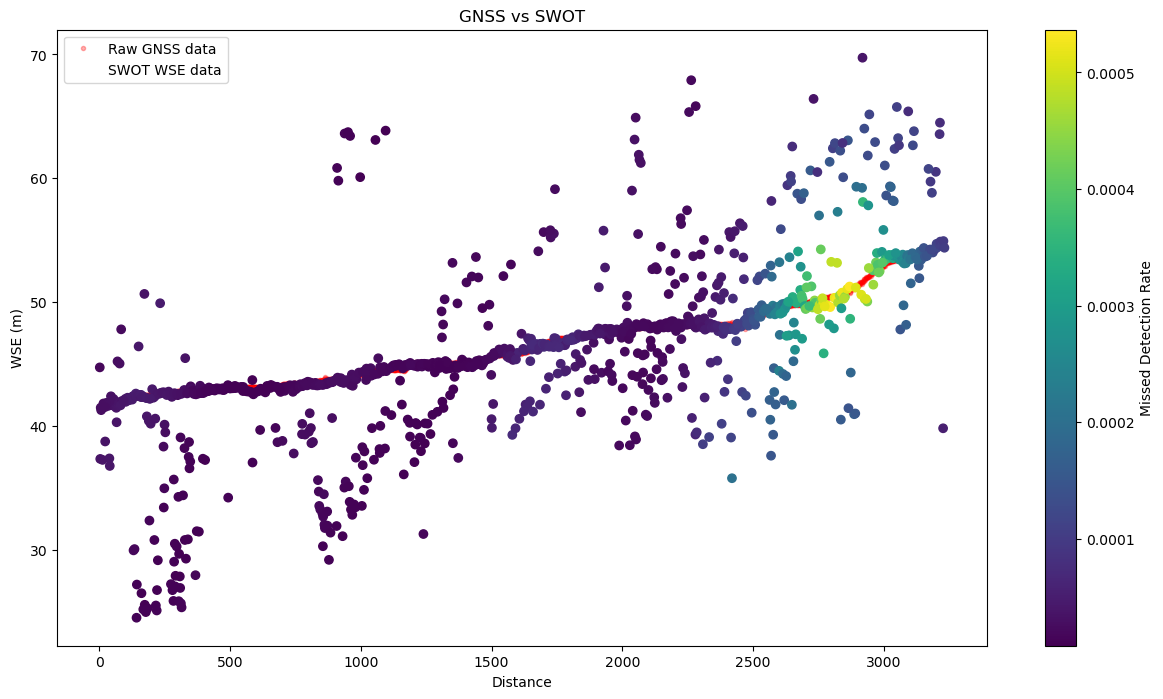

In [11]:
data = pd.read_csv(output_file_path)
data.head()

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.plot(data.cumulative_distance, data['Height(m)'], 'ro', zorder=1, markersize=3, alpha = .3, label='Raw GNSS data')
#ax.scatter(river_filtered.cumulative_distance, river_filtered['nearest_height'], color = 'royalblue', zorder=2, label='SWOT WSE data')

sc = ax.scatter(data.nearest_GNSS_dist, data['height'], 
                c=data['missed_detection_rate'], cmap='viridis', zorder=2, label='SWOT WSE data')

ax.legend()
ax.set_title('GNSS vs SWOT')
ax.set_xlabel('Distance')
ax.set_ylabel('WSE (m)')

# Add color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Missed Detection Rate')

plt.show()

In [ ]:
# Example usage:
section_id = '66190600023'
date = '20240131'
nc_file_path = 'data/2024-01-09/SWOT_L2_HR_PIXC_010_188_227L_20240131T171749_20240131T171800_PIC0_01.nc'
gnss_file_path = "data/2024-01-09/SEPT0092.csv"
sword_shp_path = '/home/b91g481/SWOT_analysis/data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = pd.to_datetime('2024-01-09 05:25:52.0000000000')
cutoff_time_2 = None
height_correction = 1.148 #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_{date}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

In [13]:
def apply_filter(df):
    return df[(df['classification'] > 2) & (df['classification'] !=5)].copy()

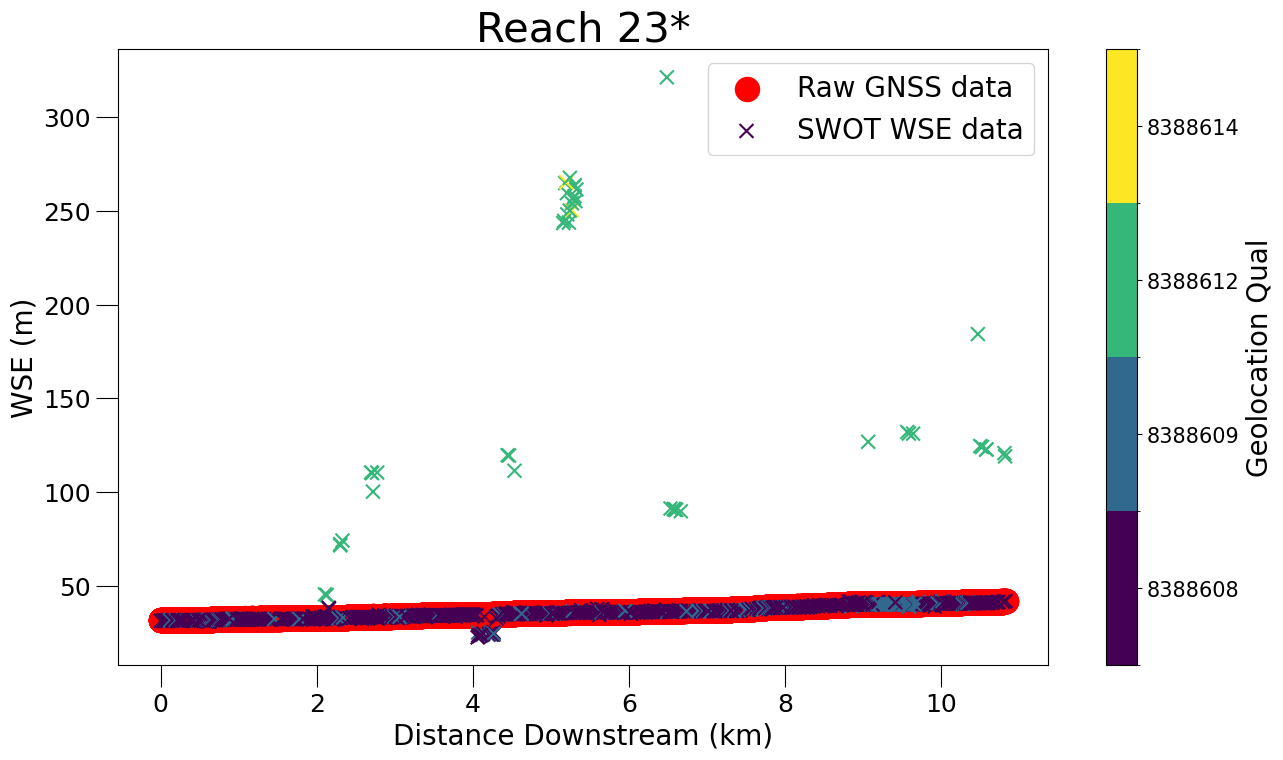

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import linregress


# Load and filter data
df = pd.read_csv(output_file_path)
df_filtered = apply_filter(df)

# Perform linear regression for GNSS
gnss_slope, gnss_intercept, _, _, _ = linregress(df['cumulative_distance'], df['Height(m)'])
# Perform linear regression for SWOT
swot_slope, swot_intercept, _, _, _ = linregress(df_filtered['nearest_GNSS_dist'], df_filtered['height'])
# Detrend GNSS data
df['Height_detrended'] = df['Height(m)'] - (gnss_slope * df['cumulative_distance'])
# Detrend SWOT data
df_filtered['height_detrended'] = df_filtered['height'] - (swot_slope * df_filtered['nearest_GNSS_dist'])

# Ensure geolocation_qual is categorical with unique values
unique_qual_values = np.unique(df_filtered['geolocation_qual'])  # Get sorted unique values
num_colors = len(unique_qual_values)

# Create a ListedColormap with a unique color for each category
cmap = plt.get_cmap('viridis', num_colors)  # Get a discrete colormap
colors = cmap(np.linspace(0, 1, num_colors))  # Generate colors
colormap = mcolors.ListedColormap(colors)  # Create colormap
norm = mcolors.BoundaryNorm(np.arange(num_colors + 1) - 0.5, num_colors)  # Ensure proper binning

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Plot raw GNSS data
ax.scatter(df.cumulative_distance / 1000, df['Height(m)'], color='red', s=300, marker='o', zorder=1, label='Raw GNSS data')

# Map geolocation_qual values to indices for coloring
geolocation_qual_indices = np.array([np.where(unique_qual_values == val)[0][0] for val in df_filtered['geolocation_qual']])

# Plot filtered SWOT WSE data with discrete colors
sc = ax.scatter(df_filtered.nearest_GNSS_dist / 1000, df_filtered['height'], s=100,
                c=geolocation_qual_indices, cmap=colormap, norm=norm, marker='x', zorder=2, label='SWOT WSE data')

# Add legend
ax.legend(fontsize=20)

# Set plot title and labels
ax.set_title('Reach 23*', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=18, size=16)
ax.set_xlabel('Distance Downstream (km)', fontsize=20)
ax.set_ylabel('WSE (m)', fontsize=20)

# Add discrete color bar
cbar = plt.colorbar(sc, ax=ax, ticks=np.arange(num_colors))  # Set colorbar to match discrete values
cbar.set_label('Geolocation Qual', fontsize=20)

# Convert tick labels to integers
cbar.ax.set_yticklabels([int(val) for val in unique_qual_values], fontsize=15)

# Define a filename based on the key
filename = f"publication_figs_2/geolocation_qual.jpg"

    # Save the figure as a high-resolution .jpg
plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')

# Show plot
plt.show()


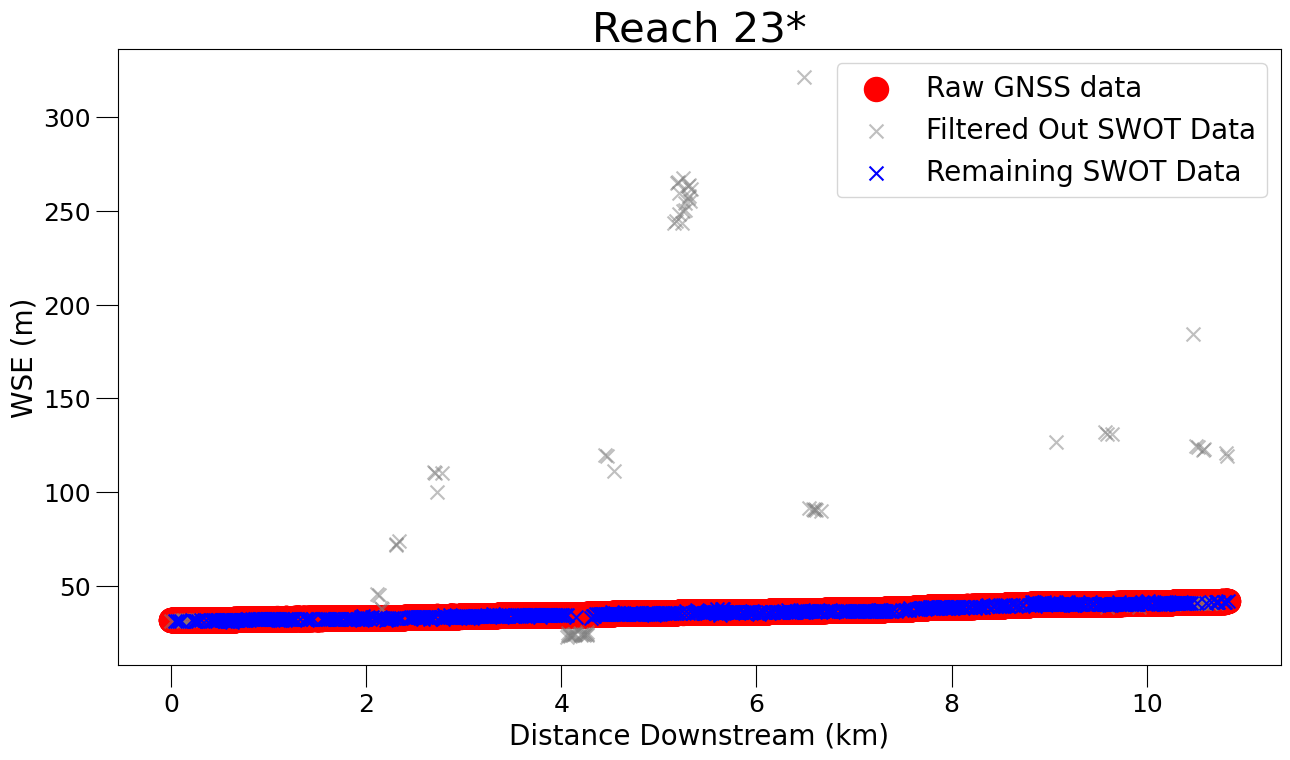

In [15]:
# Load and filter data
df = pd.read_csv(output_file_path)
df_filtered = apply_filter(df)

# Perform linear regression for GNSS
gnss_slope, gnss_intercept, _, _, _ = linregress(df['cumulative_distance'], df['Height(m)'])
# Perform linear regression for SWOT
swot_slope, swot_intercept, _, _, _ = linregress(df_filtered['nearest_GNSS_dist'], df_filtered['height'])

# Detrend GNSS data
df['Height_detrended'] = df['Height(m)'] - (gnss_slope * df['cumulative_distance'])
# Detrend SWOT data
df_filtered['height_detrended'] = df_filtered['height'] - (swot_slope * df_filtered['nearest_GNSS_dist'])

# Compute quantile thresholds
lower_quantile = df_filtered['height_detrended'].quantile(0.04)
upper_quantile = df_filtered['height_detrended'].quantile(0.93)

# Create masks for filtered-in and filtered-out SWOT data
mask_filtered_in = (df_filtered['height_detrended'] >= lower_quantile) & (df_filtered['height_detrended'] <= upper_quantile)
mask_filtered_out = ~mask_filtered_in  # Inverse mask for points that are filtered out

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Plot raw GNSS data
ax.scatter(df.cumulative_distance / 1000, df['Height(m)'], color='red', s=300, marker='o', zorder=1, label='Raw GNSS data')

# Plot filtered-out SWOT WSE data in gray
ax.scatter(df_filtered[mask_filtered_out].nearest_GNSS_dist / 1000, df_filtered[mask_filtered_out]['height'], 
           s=100, color='gray', marker='x', alpha=0.5, zorder=2, label='Filtered Out SWOT Data')

# Plot remaining SWOT WSE data in blue
ax.scatter(df_filtered[mask_filtered_in].nearest_GNSS_dist / 1000, df_filtered[mask_filtered_in]['height'], 
           s=100, color='blue', marker='x', zorder=3, label='Remaining SWOT Data')

# Add legend
ax.legend(fontsize=20)

# Set plot title and labels
ax.set_title('Reach 23*', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=18, size=16)
ax.set_xlabel('Distance Downstream (km)', fontsize=20)
ax.set_ylabel('WSE (m)', fontsize=20)

# Define a filename
filename = "publication_figs_2/swot_filtered_results.jpg"

# Save the figure as a high-resolution .jpg
plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')

# Show plot
plt.show()


In [20]:
# Example usage:
section_id = '66190600023'
nc_file_path = 'data/2024-01-09/SWOT_L2_HR_PIXC_009_145_082L_20240109T071622_20240109T071634_PGC0_01.nc'
gnss_file_path = "data/2024-01-09/SEPT0092.csv"
sword_shp_path = '/home/b91g481/SWOT_analysis/data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = pd.to_datetime('2024-01-09 05:25:52.0000000000')
cutoff_time_2 = None
height_correction = 1.148 #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

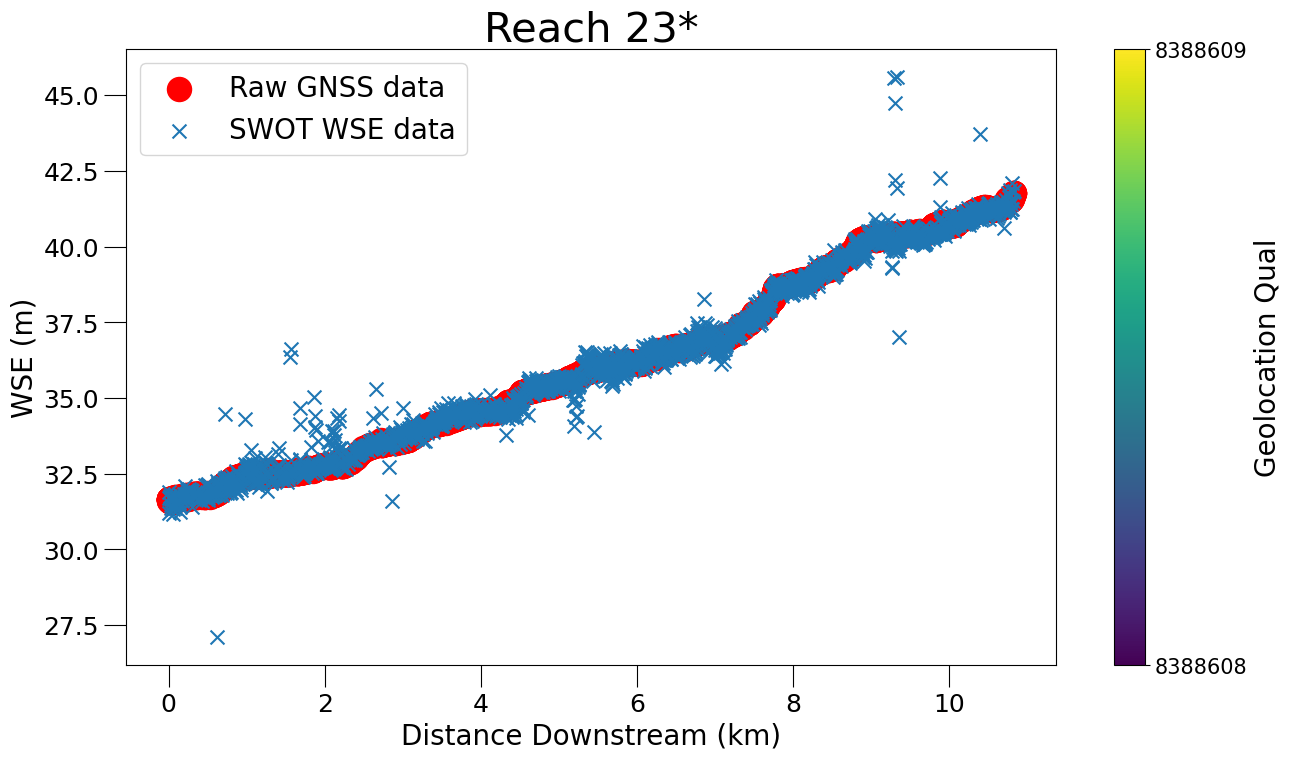

In [17]:
# Load and filter data
df = pd.read_csv(output_file_path)
df_filtered = apply_filter(df)

# Perform linear regression for GNSS
gnss_slope, gnss_intercept, _, _, _ = linregress(df['cumulative_distance'], df['Height(m)'])
# Perform linear regression for SWOT
swot_slope, swot_intercept, _, _, _ = linregress(df_filtered['nearest_GNSS_dist'], df_filtered['height'])
# Detrend GNSS data
df['Height_detrended'] = df['Height(m)'] - (gnss_slope * df['cumulative_distance'])
# Detrend SWOT data
df_filtered['height_detrended'] = df_filtered['height'] - (swot_slope * df_filtered['nearest_GNSS_dist'])

# Ensure geolocation_qual is categorical with unique values
#unique_qual_values = np.unique(df_filtered['geolocation_qual'])  # Get sorted unique values
num_colors = len(unique_qual_values)

# Create a ListedColormap with a unique color for each category
cmap = plt.get_cmap('viridis', num_colors)  # Get a discrete colormap
colors = cmap(np.linspace(0, 1, num_colors))  # Generate colors
colormap = mcolors.ListedColormap(colors)  # Create colormap
norm = mcolors.BoundaryNorm(np.arange(num_colors + 1) - 0.5, num_colors)  # Ensure proper binning

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Plot raw GNSS data
ax.scatter(df.cumulative_distance / 1000, df['Height(m)'], color='red', s=300, marker='o', zorder=1, label='Raw GNSS data')

# Map geolocation_qual values to indices for coloring
#geolocation_qual_indices = np.array([np.where(unique_qual_values == val)[0][0] for val in data_filtered['geolocation_qual']])

# Plot filtered SWOT WSE data with discrete colors
sc = ax.scatter(df_filtered.nearest_GNSS_dist / 1000, df_filtered['height'], s=100,
                #c=geolocation_qual_indices, cmap=colormap, norm=norm, 
                marker='x', zorder=2, label='SWOT WSE data')

# Add legend
ax.legend(fontsize=20)

# Set plot title and labels
ax.set_title('Reach 23*', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=18, size=16)
ax.set_xlabel('Distance Downstream (km)', fontsize=20)
ax.set_ylabel('WSE (m)', fontsize=20)

# Add discrete color bar
cbar = plt.colorbar(sc, ax=ax, ticks=np.arange(num_colors))  # Set colorbar to match discrete values
cbar.set_label('Geolocation Qual', fontsize=20)

# Convert tick labels to integers
cbar.ax.set_yticklabels([int(val) for val in unique_qual_values], fontsize=15)

# Define a filename based on the key
filename = f"publication_figs_2/geolocation_qual.jpg"

    # Save the figure as a high-resolution .jpg
plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')

# Show plot
plt.show()


In [18]:
# Example usage:
section_id = '66190600011'
nc_file_path = 'data/2024-01-10/SWOT_L2_HR_PIXC_009_188_227L_20240110T203243_20240110T203254_PIC0_01.nc'
gnss_file_path = "data/2024-01-10/SEPT0100.csv"
sword_shp_path = '/home/b91g481/SWOT_analysis/data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = None
cutoff_time_2 = pd.to_datetime('2024-01-10 22:51:11.0000000000')
height_correction = 1.134  #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

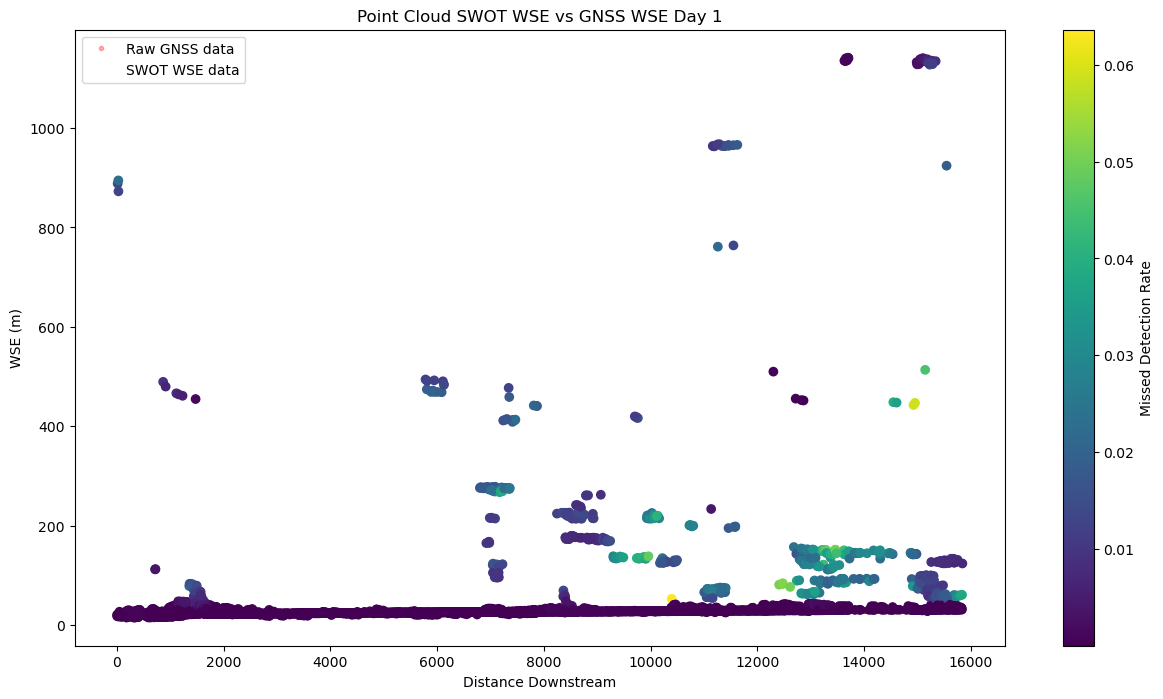

In [19]:
data = pd.read_csv(output_file_path)
data.head()

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.plot(data.cumulative_distance, data['Height(m)'], 'ro', zorder=1, markersize=3, alpha = .3, label='Raw GNSS data')
#ax.scatter(river_filtered.cumulative_distance, river_filtered['nearest_height'], color = 'royalblue', zorder=2, label='SWOT WSE data')

sc = ax.scatter(data.nearest_GNSS_dist, data['height'], 
                c=data['missed_detection_rate'], cmap='viridis', zorder=2, label='SWOT WSE data')

ax.legend()
ax.set_title('Point Cloud SWOT WSE vs GNSS WSE Day 1')
ax.set_xlabel('Distance Downstream')
ax.set_ylabel('WSE (m)')

# Add color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Missed Detection Rate')

plt.show()